# Analisi di Spiegabilità (XAI) per Modelli GNN su Dati di Brain-Imaging

### *Notebook di Analisi Esplicativa*

In questo notebook, esploreremo le predizioni di un modello Graph Neural Network (GNN) pre-addestrato per la segmentazione di tumori cerebrali. L'obiettivo non è solo valutare l'accuratezza, ma capire **perché** il modello prende determinate decisioni. Utilizzeremo diverse tecniche di Explainable AI (XAI) per identificare le feature, i nodi vicini e le connessioni più influenti.

---

## 1. Setup dell'Ambiente e Importazioni

Iniziamo importando le librerie necessarie e configurando l'ambiente di lavoro.

- **Librerie Core:** `os`, `sys`, `numpy` per la gestione del sistema e operazioni numeriche.
- **PyTorch & PyG:** `torch` è il framework di base; `torch_geometric` è la libreria essenziale per i GNN.
- **MONAI:** Utilizziamo `set_determinism` per garantire la riproducibilità degli esperimenti, un aspetto cruciale nell'analisi XAI.
- **Explainability:** Importiamo `Explainer` e `GNNExplainer` da PyG, che sono gli strumenti principali per questa analisi.
- **Visualizzazione:** `matplotlib` per la creazione di grafici.

In [1]:
# --- Librerie di base e di sistema ---
import os
import sys
import random
from sys import platform

# --- Gestione dei percorsi ---
sys.path.append('..')

# --- Framework e librerie GNN ---
import torch
from torch_geometric.explain import Explainer, ModelConfig
from torch_geometric.explain.algorithm import GNNExplainer
import numpy as np

# --- Librerie ausiliarie e di visualizzazione ---
from monai.utils import set_determinism
from src.helpers.config import get_config
from src.models.gnn import GraphSAGE, GAT, ChebNet
import matplotlib.pyplot as plt
import time

## 2. Configurazione e Riproducibilità

### 2.1 Definizione dei Percorsi
Carichiamo le configurazioni e definiamo i percorsi principali per i dati, i modelli e i report.

In [2]:
# Definisce il percorso base (la cartella principale del progetto)
_base_path = os.path.abspath('..')

# Definizione dei percorsi
_config = get_config()
data_path = os.path.join(_base_path, _config.get('DATA_FOLDER'))
graph_path = os.path.join(data_path, _config.get('GRAPH_FOLDER'))
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))

if platform == 'win32':
    data_path = data_path.replace('/', '\\')
    graph_path = graph_path.replace('/', '\\')
    saved_path = saved_path.replace('/', '\\')
    reports_path = reports_path.replace('/', '\\')
    logs_path = logs_path.replace('/', '\\')

### 2.2 Seed per la Riproducibilità
L'analisi di spiegabilità può avere componenti stocastiche. Fissare un seed è fondamentale per garantire che i risultati siano consistenti e confrontabili tra diverse esecuzioni.

In [3]:
# Impostare un seed per la riproducibilità
set_determinism(seed=3)
random.seed(3)
np.random.seed(3)
torch.manual_seed(3)

## 3. Definizione del Modello e dei Dati

### 3.1 Classi di Output
Definiamo i nomi delle classi target. Questo mapping da indici numerici a etichette testuali sarà essenziale per interpretare i risultati in modo intuitivo.

In [4]:
# --- Definizione delle Classi di Output ---
# Si mappa l'indice numerico di ogni classe a un'etichetta testuale
# per rendere più interpretabili i risultati e i grafici.

classes = [
    "Sano/Background",      # Classe 0
    "NCR/NET",              # Classe 1 (Nucleo Necrotico/Non-Enhancing)
    "Edema (ED)",           # Classe 2
    "Tumore Enhancing (ET)" # Classe 3
]

### 3.2 Architettura del Modello GNN
Qui definiamo l'architettura del nostro modello. Per questa analisi, utilizzeremo **ChebNet**, una Graph Convolutional Network basata su approssimazioni spettrali con polinomi di Chebyshev.

**Scelta di ChebNet:**
- **Localizzazione Spettrale:** Permette di definire filtri che operano in un intorno localizzato del grafo.
- **Efficienza:** Computazionalmente vantaggioso rispetto ad altri metodi spettrali.
- **Parametro K:** L'ordine del polinomio `K` definisce la dimensione del vicinato considerato da ogni "neurone" (K-hop neighborhood), un parametro chiave per l'interpretabilità.

In [5]:
# --- Definizione degli Iperparametri del Modello ---
# Questi parametri definiscono l'architettura della GNN. Vengono elencati
# per completezza, ma solo quelli di ChebNet sono attivamente usati in questo notebook.

# Parametri condivisi
num_node_features = 50          # Dimensione delle feature di input per ogni nodo
num_classes = 4                 # Numero di classi di output
dropout = .0                    # Dropout disattivato per la fase di analisi
hidden_channels = [512, 512, 512, 512, 512, 512, 512]  # Unità nascoste per ogni layer

# Parametri specifici per ChebNet
k = 4                           # Ordine del polinomio (dimensione del vicinato di convoluzione)

# --- Istanziazione del Modello ---
# Si crea l'istanza del modello ChebNet che verrà successivamente
# caricata con i pesi pre-addestrati.
model = ChebNet(
    in_channels=num_node_features,
    hidden_channels=hidden_channels,
    out_channels=num_classes,
    dropout=dropout,
    K=k
)
print(f"Modello creato: {model.__class__.__name__}")

Modello creato: ChebNet


## 4. Caricamento Dati e Selezione del Target di Analisi

### 4.1 Funzione di Caricamento
Questa funzione helper si occupa di caricare un singolo grafo (paziente) dal disco.

- Funzione per la ricerca e il caricamento di un grafo

In [6]:
# --- Funzione Helper per il Caricamento dei Dati ---
# Questa funzione carica un singolo grafo (paziente) dal disco,
# gestendo la costruzione del percorso e il controllo degli errori.

def find_and_load_graph(subject_id):
    """
    Carica un grafo specifico per l'analisi dato il suo ID.
    
    Args:
        subject_id (str): ID del soggetto (es. "BraTS-GLI-00017-001").
        
    Returns:
        (torch_geometric.data.Data, str): Tupla contenente i dati del grafo e l'ID del soggetto.
    """
    # Costruisce il percorso completo del file
    graph_file = os.path.join(graph_path, subject_id, f"{subject_id}.graph")
    
    # Controlla l'esistenza del file per prevenire errori
    if not os.path.isfile(graph_file):
        raise FileNotFoundError(f"File grafo non trovato per il soggetto {subject_id}")
    
    print(f"Caricamento grafo: {graph_file}")
    
    # Carica l'oggetto Data di PyTorch Geometric
    data = torch.load(graph_file, weights_only=False)
    
    return data, subject_id

In [7]:
# --- Caricamento del Grafo Selezionato ---
# Questa cella esegue il caricamento del grafo utilizzando l'ID del soggetto
# definito nella cella di configurazione. Se non ancora definito, usa un valore di default.

# Imposta un ID di default per testare la cella singolarmente
if 'SUBJECT_ID_TO_LOAD' not in locals():
    SUBJECT_ID_TO_LOAD = "BraTS-GLI-00000-000"
    print(f"ATTENZIONE: SUBJECT_ID_TO_LOAD non definito. Si utilizza il valore di default: {SUBJECT_ID_TO_LOAD}")

# Carica il grafo e stampa un riepilogo delle sue proprietà
try:
    print(f"--- Inizio caricamento per il soggetto: {SUBJECT_ID_TO_LOAD} ---")
    data, subject_id = find_and_load_graph(SUBJECT_ID_TO_LOAD)
    print(f"Grafo caricato con successo: {subject_id}")
    print(f"  - Numero di nodi: {data.num_nodes}")
    print(f"  - Numero di archi: {data.num_edges}")
    print(f"  - Numero di feature per nodo: {data.num_node_features}")
except (FileNotFoundError, IOError) as e:
    print(f"ERRORE: {e}")
    # Interrompe l'esecuzione se il file non viene trovato
    raise e

ATTENZIONE: SUBJECT_ID_TO_LOAD non definito. Si utilizza il valore di default: BraTS-GLI-00000-000
--- Inizio caricamento per il soggetto: BraTS-GLI-00000-000 ---
Caricamento grafo: C:\Users\gianluca\Desktop\brain-tumor-graph-segmentation-main\data\graphs\BraTS-GLI-00000-000\BraTS-GLI-00000-000.graph
Grafo caricato con successo: BraTS-GLI-00000-000
  - Numero di nodi: 2946
  - Numero di archi: 29460
  - Numero di feature per nodo: 50


### 4.2 Pannello di Controllo dell'Analisi
Questa è la cella più importante per guidare l'esperimento. Qui definiamo:
1.  **Quale paziente (`subject_id`) analizzare.**
2.  **Come selezionare il nodo (`NODE_SELECTION_METHOD`)** da spiegare all'interno del grafo del paziente.

Questo approccio permette di rieseguire l'analisi su target diversi in modo rapido e controllato.

In [8]:
# ======================================================================
#                   PANNELLO DI CONTROLLO SPERIMENTALE
# ======================================================================
# Questa cella centralizza i parametri per l'analisi di spiegabilità,
# permettendo di modificare l'oggetto dello studio senza alterare il codice sottostante.

# --- 1. Selezione del Soggetto di Studio (Grafo) ---
# Specifica l'identificativo del soggetto (grafo) da caricare per l'analisi.
# La selezione può essere guidata dai risultati ottenuti in fase di test,
# focalizzandosi su casi di particolare interesse (es. predizioni incerte o errate).
SUBJECT_ID_TO_LOAD = "BraTS-GLI-00017-001"


# --- 2. Criterio di Selezione del Nodo Target per la Spiegabilità ---
# Definisce la strategia per l'identificazione automatica del nodo (superpixel)
# la cui predizione verrà spiegata.
#
# Strategie disponibili:
# 'highest_confidence': Nodo con la massima probabilità per la classe corretta.
#                       (Utile per validare ciò che il modello considera un "esempio perfetto").
# 'lowest_confidence':  Nodo corretto con la minima probabilità > 0.5.
#                       (Utile per analizzare casi di incertezza).
# 'first_incorrect':    Primo nodo classificato erroneamente.
#                       (Cruciale per il debug e la comprensione degli errori).
# 'random_correct':     Selezione stocastica di un nodo corretto.
# 'random_incorrect':   Selezione stocastica di un nodo errato.
# 'specific_class':     Analisi mirata su una specifica classe di tessuto.
# 'specific_index':     Selezione manuale di un nodo di interesse pre-identificato.
NODE_SELECTION_METHOD = 'lowest_confidence'

# --- Parametri Dipendenti dal Metodo di Selezione ---

# Per 'specific_class': definire l'indice della classe di tessuto target.
# Mapping: 0:Sano, 1:NCR/NET, 2:Edema, 3:Tumore Enhancing (ET)
TARGET_CLASS_FOR_SELECTION = 3

# Per 'specific_index': definire l'indice del nodo da analizzare.
TARGET_INDEX_FOR_SELECTION = 847

# --- Riepilogo della Configurazione ---
print("--- Configurazione dell'analisi impostata ---")
print(f"Grafo da caricare: {SUBJECT_ID_TO_LOAD}")
print(f"Criterio di selezione del nodo: {NODE_SELECTION_METHOD}")
if NODE_SELECTION_METHOD == 'specific_class':
    print(f"Classe target per la selezione: {TARGET_CLASS_FOR_SELECTION} ({classes[TARGET_CLASS_FOR_SELECTION]})")
if NODE_SELECTION_METHOD == 'specific_index':
    print(f"Indice specifico del nodo target: {TARGET_INDEX_FOR_SELECTION}")

--- Configurazione dell'analisi impostata ---
Grafo da caricare: BraTS-GLI-00017-001
Criterio di selezione del nodo: lowest_confidence


### 4.3 Caricamento del Modello Pre-addestrato e Valutazione
Ora carichiamo i pesi del miglior modello ChebNet salvato durante l'addestramento e verifichiamo la sua performance sul grafo selezionato. Questo ci dà un contesto sull'affidabilità delle predizioni che andremo a spiegare.

In [9]:
# --- Caricamento dei Pesi del Modello Pre-addestrato ---
# Si identificano i file del modello ChebNet salvati durante l'addestramento.
# Viene selezionato e caricato l'ultimo modello "best" disponibile.

# Cerca i file del modello nella cartella dei modelli salvati
model_files = [f for f in os.listdir(saved_path) if 'CHEBNET' in f and f.endswith('_best.pth')]

if not model_files:
    raise FileNotFoundError("Nessun modello ChebNet pre-addestrato trovato nella directory 'saved/'.")

# Seleziona il modello più recente (assumendo un ordinamento temporale)
latest_model = sorted(model_files)[-1]
print(f"Utilizzo del modello pre-addestrato: {latest_model}")

# Carica i pesi nel modello istanziato e lo imposta in modalità valutazione
model.load_state_dict(torch.load(os.path.join(saved_path, latest_model), map_location=torch.device('cpu')))
model.eval()

Utilizzo del modello pre-addestrato: CHEBNET_1739029370_best.pth


ChebNet(
  (layers): ModuleList(
    (0): ChebConv(50, 512, K=4, normalization=sym)
    (1-6): 6 x ChebConv(512, 512, K=4, normalization=sym)
    (7): ChebConv(512, 4, K=4, normalization=sym)
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

## **Valutazione dell'Accuratezza**

- Verifica dell'accuratezza del modello sul grafo caricato.

In [10]:
# --- Valutazione del Modello sul Grafo Selezionato ---
# Si eseguono le predizioni sul grafo caricato per ottenere un contesto
# sulla performance del modello in questo specifico caso.

with torch.no_grad(): # Disattiva il calcolo dei gradienti per l'inferenza
    # Esegue il forward pass del modello
    outputs = model(data.x, data.edge_index.type(torch.int64))
    
    # Ottiene le etichette predette prendendo la classe con il punteggio più alto
    predicted_labels = outputs.argmax(dim=1)

    # Calcola e stampa l'accuratezza complessiva sul grafo
    # Confronta le etichette predette con quelle reali (ground truth)
    try:
        correct_predictions = (predicted_labels == data.y.long())
        accuracy = correct_predictions.float().mean().item()
        print(f"Accuratezza del modello sul grafo {subject_id}: {accuracy:.4f}")
    except Exception as e:
        print(f"Avviso: impossibile calcolare l'accuratezza. Etichette reali 'data.y' potrebbero mancare o avere un formato non valido. Errore: {e}")

    # Calcola e stampa la distribuzione delle classi predette
    class_counts = torch.bincount(predicted_labels, minlength=num_classes)
    print(f"Distribuzione delle classi predette: {class_counts.numpy()}")

Accuratezza del modello sul grafo BraTS-GLI-00000-000: 0.9922
Distribuzione delle classi predette: [2825   22   28   71]


In [11]:
# --- Selezione Automatica del Nodo Target ---
# Questa cella implementa la logica per selezionare un singolo nodo da analizzare,
# basandosi sui criteri definiti nel "Pannello di Controllo Sperimentale".

import torch.nn.functional as F

print("\n--- Selezione del nodo target in base alla configurazione ---")

# Calcola le probabilità di predizione per tutti i nodi
with torch.no_grad():
    all_logits = model(data.x, data.edge_index.type(torch.int64))
    all_probs = F.softmax(all_logits, dim=1)
    max_probs, _ = torch.max(all_probs, dim=1)

# Crea maschere booleane per nodi predetti correttamente o erroneamente
correct_preds_mask = (predicted_labels == data.y.long())
incorrect_preds_mask = ~correct_preds_mask

# Applica la strategia di selezione definita dalla variabile NODE_SELECTION_METHOD
selected_node_index = -1
if NODE_SELECTION_METHOD == 'highest_confidence':
    candidates = correct_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[max_probs[candidates].argmax()].item()

elif NODE_SELECTION_METHOD == 'lowest_confidence':
    # Considera solo nodi corretti con probabilità > 0.5
    low_conf_mask = (max_probs > 0.5)
    candidates = (correct_preds_mask & low_conf_mask).nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[max_probs[candidates].argmin()].item()

elif NODE_SELECTION_METHOD == 'first_incorrect':
    candidates = incorrect_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[0].item()

elif NODE_SELECTION_METHOD == 'random_correct':
    candidates = correct_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = random.choice(candidates.tolist())

elif NODE_SELECTION_METHOD == 'random_incorrect':
    candidates = incorrect_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = random.choice(candidates.tolist())

elif NODE_SELECTION_METHOD == 'specific_class':
    class_mask = (predicted_labels == TARGET_CLASS_FOR_SELECTION)
    candidates = class_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = random.choice(candidates.tolist())

elif NODE_SELECTION_METHOD == 'specific_index':
    selected_node_index = TARGET_INDEX_FOR_SELECTION

# Gestisce il caso in cui nessun nodo soddisfi i criteri, selezionandone uno casuale
if selected_node_index == -1:
    print(f"ATTENZIONE: Nessun nodo trovato con il metodo '{NODE_SELECTION_METHOD}'. Si seleziona un nodo casuale.")
    selected_node_index = random.randint(0, data.num_nodes - 1)

# Assegna l'indice del nodo selezionato a una variabile per l'uso nelle celle successive
node_to_explain_index = selected_node_index

# Stampa un riepilogo del nodo selezionato per l'analisi
pred_class_idx = predicted_labels[node_to_explain_index].item()
real_class_idx = data.y[node_to_explain_index].long().item()
print(f"\n---> NODO SELEZIONATO PER LE PROSSIME ANALISI: Indice {node_to_explain_index} <---")
print(f"  - Classe Predetta: {classes[pred_class_idx]} (Prob: {max_probs[node_to_explain_index]:.4f})")
print(f"  - Classe Reale:    {classes[real_class_idx]}")
print(f"  - Predizione:      {'Corretta' if pred_class_idx == real_class_idx else 'ERRATA'}")


--- Selezione del nodo target in base alla configurazione ---

---> NODO SELEZIONATO PER LE PROSSIME ANALISI: Indice 1562 <---
  - Classe Predetta: Sano/Background (Prob: 0.5449)
  - Classe Reale:    Sano/Background
  - Predizione:      Corretta


## 5. Tecniche di Spiegabilità (XAI)

Applicheremo tre diverse tecniche XAI per ottenere una visione completa e robusta di ciò che il modello ha imparato.

### 5.1 Metodo Basato sul Modello: GNNExplainer
**GNNExplainer** è un metodo *model-specific* che apprende una maschera "soft" sul grafo di calcolo del nodo target. Cerca di trovare il sottografo e il sottoinsieme di feature più piccoli ma più influenti per la predizione.

- **Cosa Spiega:** L'importanza di **feature** e **archi (vicini)**.
- **Come Funziona:** Ottimizza una maschera per massimizzare l'informazione mutua tra la predizione del modello e la distribuzione del sottografo.
- **Punti di Forza:** Fornisce una spiegazione strutturata (sottografo) e basata sulle feature.

In [12]:
# ======================================================================
#         METODO DI SPIEGABILITÀ 1: GNNEXPLAINER
# ======================================================================
# Si utilizza GNNExplainer per identificare il sottografo e le feature
# più influenti per la predizione del nodo target selezionato.

import torch.nn.functional as F

# --- 1. Configurazione dell'Algoritmo GNNExplainer ---
# Si impostano i parametri per l'apprendimento della maschera.
# I coefficienti (coeffs) servono a regolarizzare la spiegazione,
# promuovendo maschere "sparse" (poche feature e pochi archi importanti).
gnn_explainer_algorithm = GNNExplainer(
    epochs=200,
    lr=0.01,
    coeffs={
        "edge_size": 0.005,      # Penalità sulla dimensione del sottografo
        "node_feat_size": 1.0,   # Penalità sull'uso delle feature
        "edge_ent": 1.0,         # Regolarizzazione sull'entropia degli archi
        "node_feat_ent": 0.1,    # Regolarizzazione sull'entropia delle feature
    }
)

# --- 2. Configurazione dell'Oggetto Explainer ---
# Si definisce il task (classificazione di nodi) e il tipo di output
# che GNNExplainer deve aspettarsi dal modello.
model_config = ModelConfig(
    mode="multiclass_classification",
    task_level="node",
    # Se il modello restituisce logits, cambiare in "raw".
    # Se restituisce probabilità logaritmiche (come dopo LogSoftmax), usare "log_probs".
    return_type="raw"
)

# Si crea l'oggetto Explainer principale
explainer = Explainer(
    model=model,
    algorithm=gnn_explainer_algorithm,
    explanation_type="phenomenon",
    model_config=model_config,
    node_mask_type="attributes",   # Chiede di spiegare l'importanza delle feature
    edge_mask_type="object",       # Chiede di spiegare l'importanza degli archi
)

# --- 3. Generazione della Spiegazione ---
# Si esegue l'algoritmo sul nodo target precedentemente identificato.
print(f"\n--- Esecuzione di GNNExplainer per il nodo: {node_to_explain_index} ---")
start_time = time.time()

# Si genera la spiegazione per il nodo specifico (index)
# rispetto all'insieme di tutte le predizioni (target).
explanation = explainer(
    x=data.x,
    edge_index=data.edge_index.type(torch.int64),
    index=node_to_explain_index,
    target=predicted_labels.type(torch.LongTensor)
)

elapsed_time = time.time() - start_time
print(f"Spiegazione generata in {elapsed_time:.2f} secondi.")

# --- 4. Riepilogo dei Risultati della Spiegazione ---
# Si stampano le informazioni principali restituite da GNNExplainer.
print("\n--- Informazioni sulla Spiegazione Generata ---")
if hasattr(explanation, 'node_mask') and explanation.node_mask is not None:
    print(f"Ottenuta maschera di importanza per le feature (node_mask) di forma: {explanation.node_mask.shape}")
else:
    print("Maschera per le feature (node_mask) non generata.")

if hasattr(explanation, 'edge_mask') and explanation.edge_mask is not None:
    print(f"Ottenuta maschera di importanza per gli archi (edge_mask) di forma: {explanation.edge_mask.shape}")
else:
    print("Maschera per gli archi (edge_mask) non generata.")


--- Esecuzione di GNNExplainer per il nodo: 1562 ---
Spiegazione generata in 500.79 secondi.

--- Informazioni sulla Spiegazione Generata ---
Ottenuta maschera di importanza per le feature (node_mask) di forma: torch.Size([2946, 50])
Ottenuta maschera di importanza per gli archi (edge_mask) di forma: torch.Size([29460])


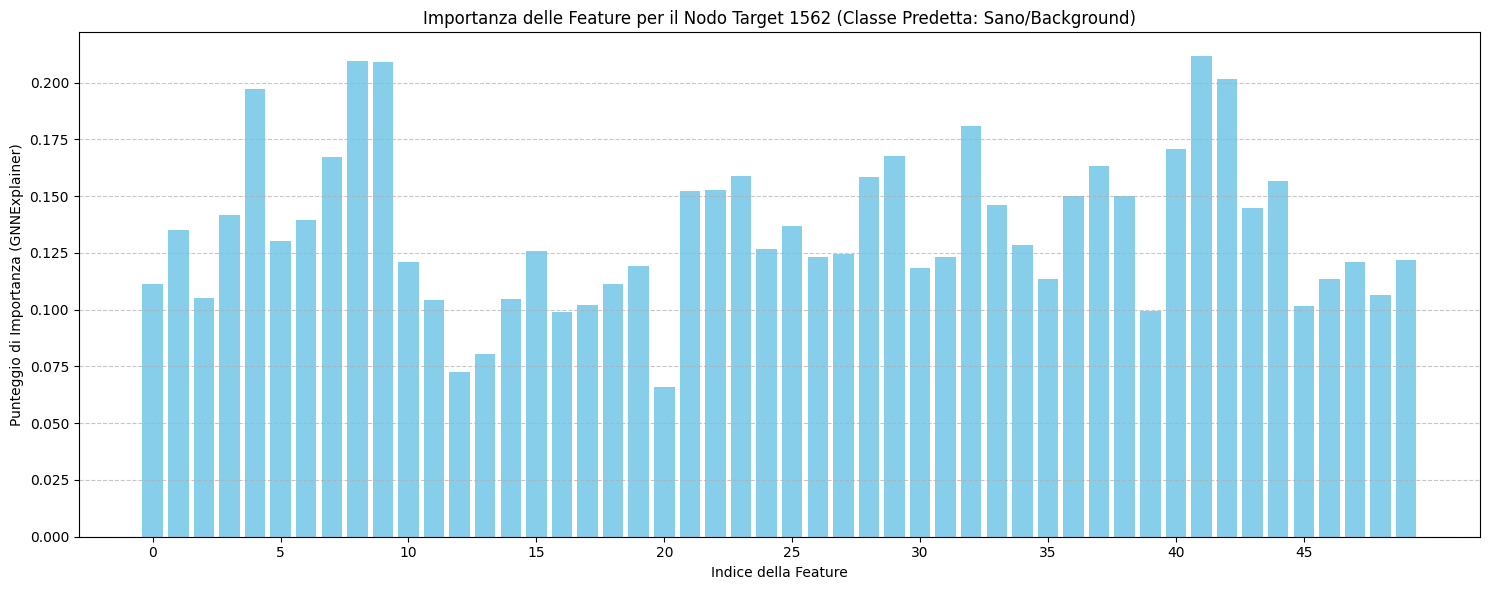


Top 10 feature più importanti per il nodo 1562:
  - Feature 41: Importanza = 0.2116
  - Feature 8: Importanza = 0.2097
  - Feature 9: Importanza = 0.2090
  - Feature 42: Importanza = 0.2016
  - Feature 4: Importanza = 0.1973
  - Feature 32: Importanza = 0.1808
  - Feature 40: Importanza = 0.1708
  - Feature 29: Importanza = 0.1676
  - Feature 7: Importanza = 0.1672
  - Feature 37: Importanza = 0.1635


In [13]:
# --- Visualizzazione dell'Importanza delle Feature (GNNExplainer) ---
# Si analizza e visualizza la maschera di importanza delle feature (node_mask)
# restituita da GNNExplainer per il nodo target.

# Controlla che la maschera delle feature esista e abbia il formato corretto
if hasattr(explanation, 'node_mask') and explanation.node_mask is not None:

    # Estrae i punteggi di importanza per le feature del solo nodo target
    target_feature_importances = explanation.node_mask[node_to_explain_index].cpu().detach().numpy()
    
    # --- Grafico a Barre: Importanza di tutte le feature ---
    plt.figure(figsize=(15, 6))
    bar_positions = np.arange(num_node_features)
    plt.bar(bar_positions, target_feature_importances, color='skyblue')
    
    plt.xlabel("Indice della Feature")
    plt.ylabel("Punteggio di Importanza (GNNExplainer)")
    plt.title(f"Importanza delle Feature per il Nodo Target {node_to_explain_index} (Classe Predetta: {classes[predicted_labels[node_to_explain_index].item()]})")
    plt.xticks(bar_positions[::5]) # Mostra un tick ogni 5 feature per leggibilità
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- Stampa delle Top K Feature ---
    # Ordina le feature per importanza e stampa le più rilevanti.
    k_top_features = 10
    sorted_feature_indices = np.argsort(target_feature_importances)[::-1] # Ordine decrescente
    
    print(f"\nTop {k_top_features} feature più importanti per il nodo {node_to_explain_index}:")
    for i in range(min(k_top_features, num_node_features)):
        feat_idx = sorted_feature_indices[i]
        importance = target_feature_importances[feat_idx]
        print(f"  - Feature {feat_idx}: Importanza = {importance:.4f}")
        
else:
    print("Analisi non eseguibile: 'explanation.node_mask' non è presente o ha un formato inatteso.")


--- Analisi degli Archi per il Nodo Target: 1562 ---

Top 15 archi più importanti connessi al nodo 1562:
Arco (u, v)     Importanza      Classe Nodo U             Classe Nodo V            
--------------------------------------------------------------------------------
(1562-1565)      0.1531          Sano/Background           Sano/Background          
(1562-1652)      0.1530          Sano/Background           Tumore Enhancing (ET)    
(1505-1562)      0.1517          Sano/Background           Sano/Background          
(1562-1500)      0.1513          Sano/Background           Sano/Background          
(1503-1562)      0.1512          Edema (ED)                Sano/Background          
(1562-1835)      0.1499          Sano/Background           Sano/Background          
(1562-1558)      0.1499          Sano/Background           Sano/Background          
(1733-1562)      0.1492          Sano/Background           Sano/Background          
(1562-1273)      0.1489          Sano/Background 

C:\Users\gianluca\AppData\Local\Temp\ipykernel_15736\1919817581.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


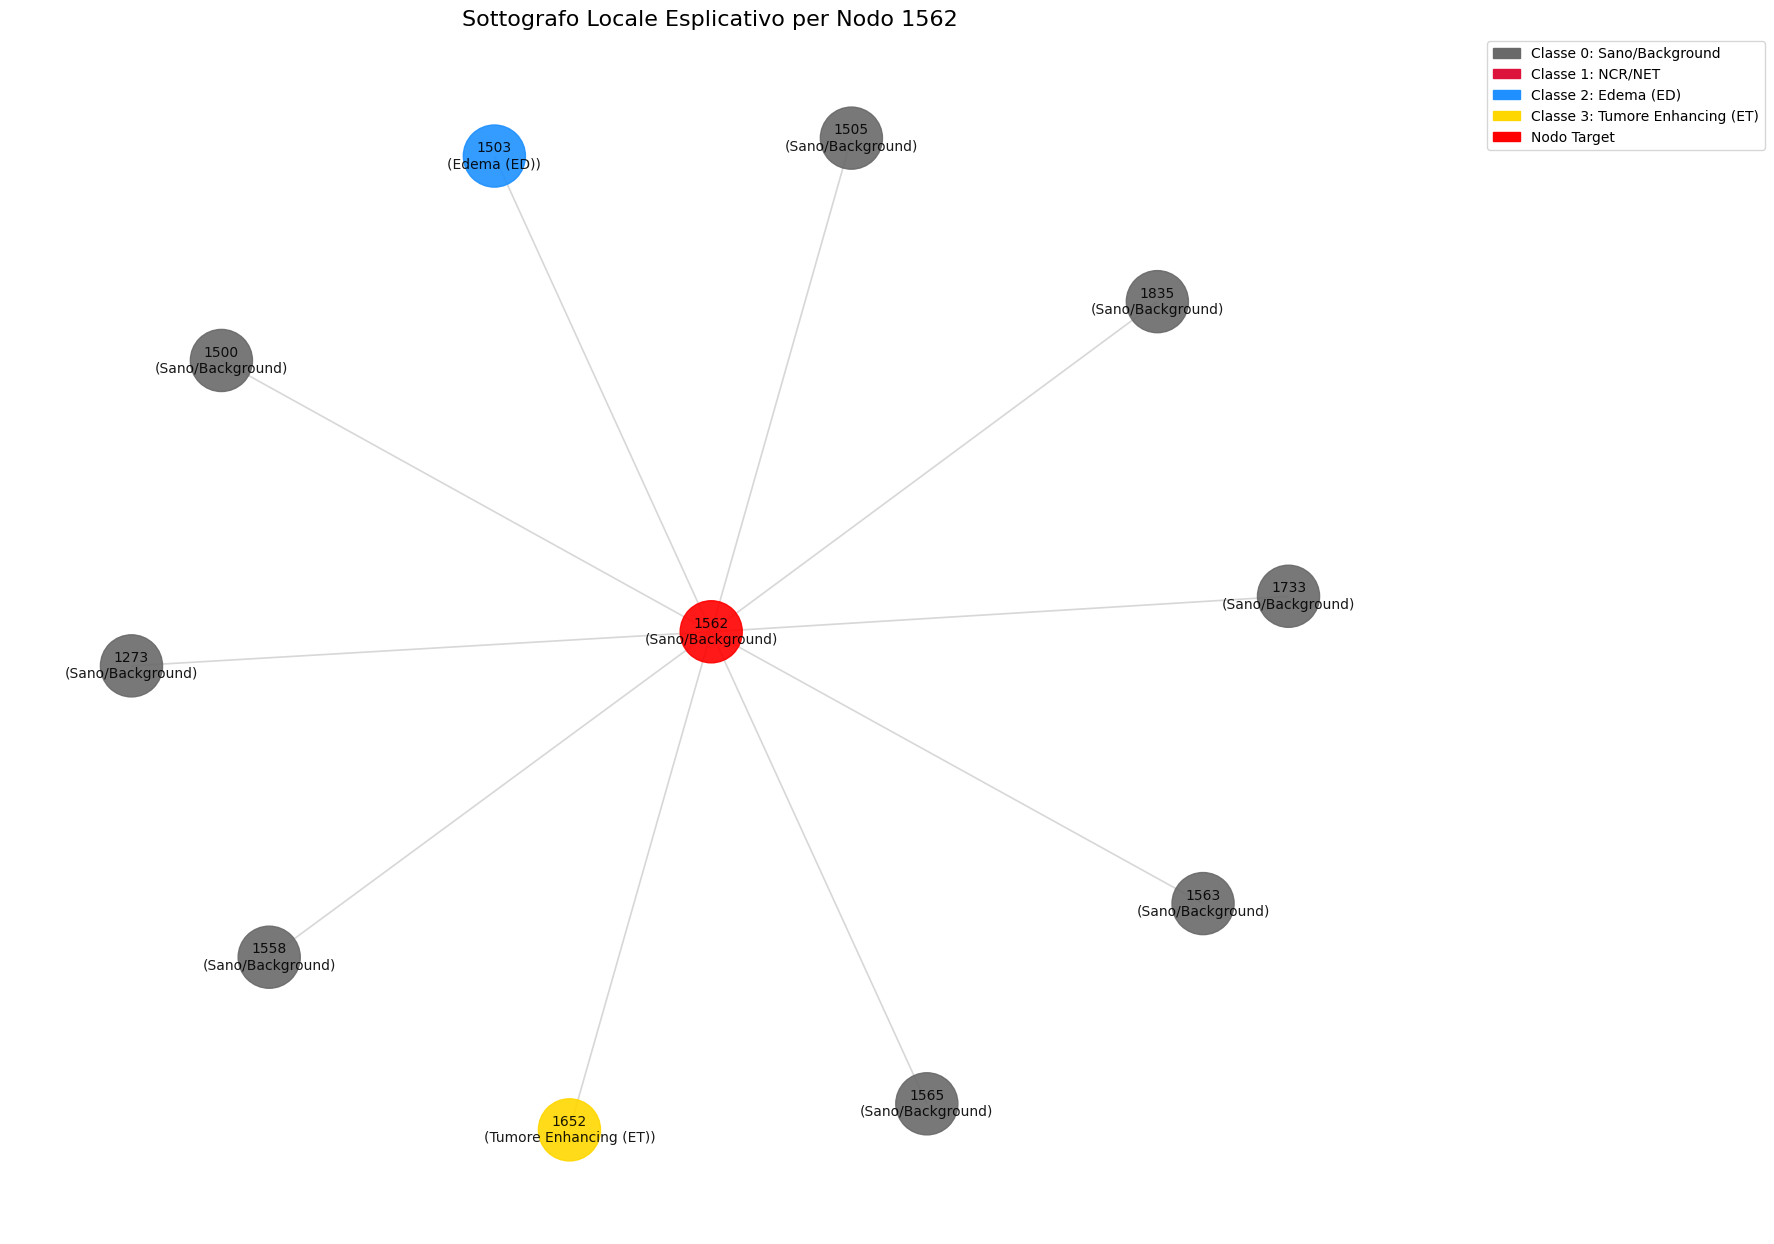

In [14]:
# --- Analisi dell'Importanza degli Archi e dei Vicini (GNNExplainer) ---
# Si analizza la maschera di importanza degli archi (edge_mask) per identificare
# le connessioni e i nodi vicini più influenti per la predizione del nodo target.

if hasattr(explanation, 'edge_mask') and explanation.edge_mask is not None:
    edge_importances = explanation.edge_mask.cpu().detach().numpy()
    edge_index = data.edge_index.cpu().numpy()

    print(f"\n--- Analisi degli Archi per il Nodo Target: {node_to_explain_index} ---")
    
    # 1. Isola gli archi connessi al nodo target e la loro importanza
    connected_edges_info = []
    for i in range(edge_index.shape[1]):
        u, v = int(edge_index[0, i]), int(edge_index[1, i])
        if u == node_to_explain_index or v == node_to_explain_index:
            connected_edges_info.append((edge_importances[i], u, v))
    
    # Ordina gli archi per importanza decrescente
    connected_edges_info.sort(key=lambda x: x[0], reverse=True)

    # 2. Stampa tabellare dei top K archi più importanti
    k_top_edges = 15
    print(f"\nTop {k_top_edges} archi più importanti connessi al nodo {node_to_explain_index}:")
    print(f"{'Arco (u, v)':<15} {'Importanza':<15} {'Classe Nodo U':<25} {'Classe Nodo V':<25}")
    print("-" * 80)

    if not connected_edges_info:
        print("Nessun arco rilevante trovato per il nodo target.")
    else:
        # Aggrega l'importanza per ogni vicino
        neighbor_importance = {}
        for importance, u, v in connected_edges_info:
            neighbor_node = v if u == node_to_explain_index else u
            neighbor_importance[neighbor_node] = neighbor_importance.get(neighbor_node, 0) + importance

        # Stampa i top archi
        for importance, u, v in connected_edges_info[:k_top_edges]:
            class_u = classes[int(predicted_labels[u].item())]
            class_v = classes[int(predicted_labels[v].item())]
            print(f"({u}-{v}){'':<5} {importance:<15.4f} {class_u:<25} {class_v:<25}")

        # 3. Visualizzazione del sottografo locale esplicativo
        try:
            import networkx as nx
            import matplotlib.patches as mpatches
            
            # Prepara i nodi e gli archi per la visualizzazione
            top_neighbors = sorted(neighbor_importance.items(), key=lambda item: item[1], reverse=True)[:k_top_edges]
            nodes_to_plot = {node_to_explain_index}.union({n[0] for n in top_neighbors})
            
            G = nx.Graph()
            node_colors = []
            node_labels = {}
            
            # Colori per le classi
            color_map = {0: '#696969', 1: '#DC143C', 2: '#1E90FF', 3: '#FFD700'} # Grigio, Rosso, Blu, Giallo

            for node in nodes_to_plot:
                G.add_node(node)
                class_idx = int(predicted_labels[node].item())
                node_labels[node] = f"{node}\n({classes[class_idx]})"
                node_colors.append('red' if node == node_to_explain_index else color_map.get(class_idx, 'grey'))

            # Aggiunge solo gli archi più importanti che collegano i nodi nel nostro plot
            edges_to_plot = []
            edge_widths = []
            for importance, u, v in connected_edges_info:
                if u in nodes_to_plot and v in nodes_to_plot:
                    edges_to_plot.append((u,v))
                    edge_widths.append(max(0.2, importance * 8)) # Scala l'importanza per la larghezza
                if len(edges_to_plot) >= k_top_edges:
                    break
            
            G.add_edges_from(edges_to_plot)

            # Creazione del grafico
            plt.figure(figsize=(14, 12))
            pos = nx.spring_layout(G, k=0.8, iterations=50, seed=3)
            nx.draw(G, pos, labels=node_labels, with_labels=True, 
                    node_color=node_colors, node_size=2000, font_size=10, 
                    width=edge_widths, font_color='black', edge_color='lightgray', alpha=0.9)

            # Creazione della legenda
            legend_patches = [mpatches.Patch(color=color, label=f'Classe {i}: {name}') for i, (name, color) in enumerate(zip(classes, color_map.values()))]
            legend_patches.append(mpatches.Patch(color='red', label='Nodo Target'))
            plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
            
            plt.title(f"Sottografo Locale Esplicativo per Nodo {node_to_explain_index}", fontsize=16)
            plt.tight_layout(rect=[0, 0, 0.85, 1])
            plt.show()

        except ImportError:
            print("Avviso: NetworkX non è installato. La visualizzazione del grafo è stata saltata.")

else:
    print("Analisi non eseguibile: 'explanation.edge_mask' non è presente.")

#### Interpretazione dei Risultati di GNNExplainer

1.  **Importanza delle Feature (Grafico a Barre):** Il primo grafico mostra quali delle 50 feature di input sono state più importanti per la classificazione del nodo target. Valori alti indicano che GNNExplainer ha ritenuto quelle feature cruciali.
2.  **Importanza degli Archi (Tabella e Grafo):** La tabella e il grafo locale mostrano quali connessioni (e quindi quali vicini) hanno avuto il maggiore impatto. L'importanza aggregata degli archi ci dice quali vicini sono più influenti nel loro insieme.

**Analisi:** Notiamo che il modello si basa molto sulle connessioni con altri nodi della stessa classe (es. ET -> ET), ma anche il contesto fornito da nodi di classi diverse (es. Edema o Sano) è rilevante, probabilmente per definire i "bordi" della regione tumorale.

### 5.2 Metodo Basato sul Gradiente: Saliency Maps

Le **Saliency Maps** sono una delle tecniche XAI più semplici e veloci. Calcolano il gradiente della probabilità della classe predetta rispetto alle feature di input del nodo.

- **Cosa Spiega:** Quali **feature** di input, se leggermente perturbate, causerebbero il maggior cambiamento nel punteggio della classe predetto.
- **Come Funziona:** Un semplice backpropagation.
- **Punti di Forza:** Veloce e facile da implementare


--- Esecuzione di Saliency Maps per il nodo: 1562 ---
Classe predetta da spiegare: Sano/Background


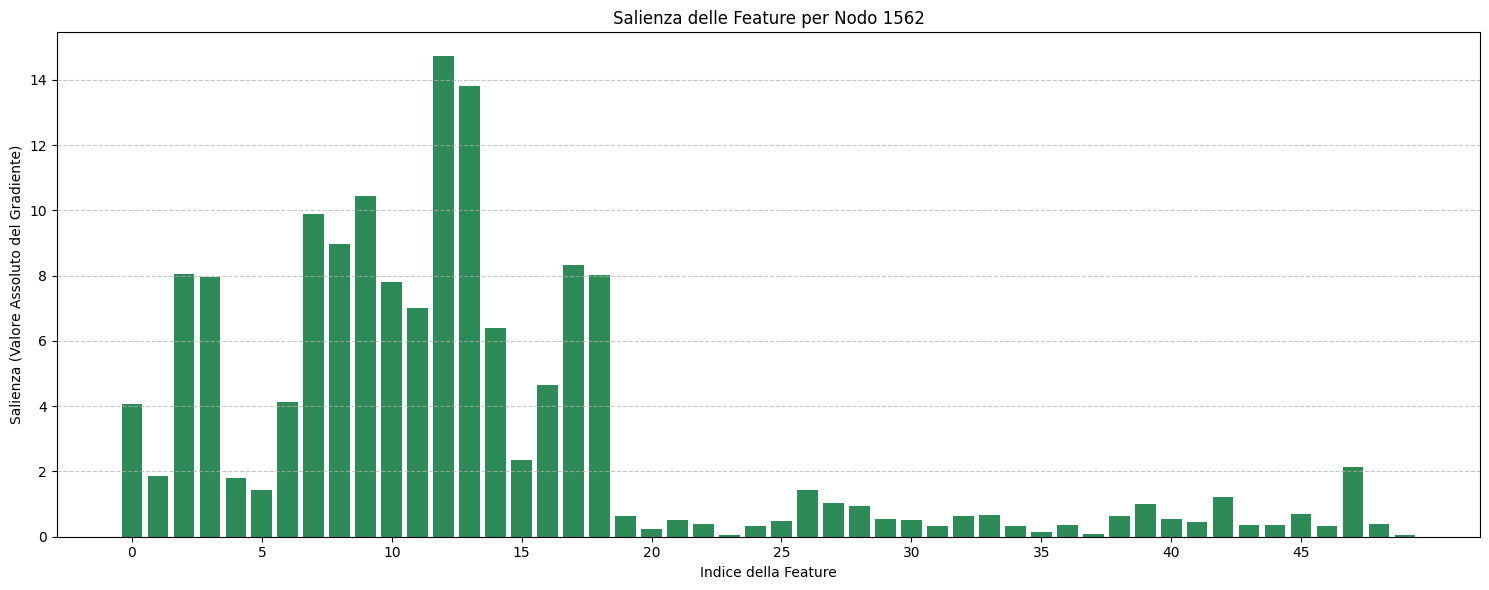


Top 10 feature più salienti per il nodo 1562:
  - Feature 12: Salienza = 14.7229
  - Feature 13: Salienza = 13.8034
  - Feature 9: Salienza = 10.4329
  - Feature 7: Salienza = 9.8900
  - Feature 8: Salienza = 8.9690
  - Feature 17: Salienza = 8.3153
  - Feature 2: Salienza = 8.0522
  - Feature 18: Salienza = 8.0326
  - Feature 3: Salienza = 7.9722
  - Feature 10: Salienza = 7.8001


In [15]:
# ======================================================================
#         METODO DI SPIEGABILITÀ 2: SALIENCY MAPS
# ======================================================================
# Si utilizza una mappa di salienza basata sul gradiente per identificare
# le feature di input più influenti per la predizione del nodo target.

print("\n--- Esecuzione di Saliency Maps per il nodo:", node_to_explain_index, "---")

# 1. Prepara l'input per il calcolo del gradiente
# È necessario clonare l'input e abilitare il tracciamento del gradiente.
x_for_saliency = data.x.clone().requires_grad_(True)
model.zero_grad() # Azzera gradienti precedenti

# 2. Esegue il forward pass per ottenere i logits
logits = model(x_for_saliency, data.edge_index.type(torch.int64))

# 3. Calcola il gradiente
# Si isola il punteggio del nodo target per la classe predetta e si esegue la backpropagation.
target_class_idx = predicted_labels[node_to_explain_index].item()
score_to_explain = logits[node_to_explain_index, target_class_idx]
score_to_explain.backward()

# 4. Estrae e analizza la mappa di salienza
# Il gradiente dell'input rappresenta la mappa di salienza.
# Si considera il valore assoluto, poiché interessa l'intensità dell'impatto.
saliency_map = x_for_saliency.grad[node_to_explain_index].abs().cpu().detach().numpy()

# --- 5. Visualizzazione dei Risultati ---
print(f"Classe predetta da spiegare: {classes[target_class_idx]}")

plt.figure(figsize=(15, 6))
bar_positions = np.arange(num_node_features)
plt.bar(bar_positions, saliency_map, color='seagreen')

plt.xlabel("Indice della Feature")
plt.ylabel("Salienza (Valore Assoluto del Gradiente)")
plt.title(f"Salienza delle Feature per Nodo {node_to_explain_index}")
plt.xticks(bar_positions[::5])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Stampa delle Top K feature più salienti
k_top_features = 10
sorted_indices = np.argsort(saliency_map)[::-1]

print(f"\nTop {k_top_features} feature più salienti per il nodo {node_to_explain_index}:")
for i in range(min(k_top_features, num_node_features)):
    feat_idx = sorted_indices[i]
    importance = saliency_map[feat_idx]
    print(f"  - Feature {feat_idx}: Salienza = {importance:.4f}")

### 5.3 Metodo Basato sulla Perturbazione: Occlusion Analysis

L'**Analisi di Occlusione** è un approccio intuitivo e *model-agnostic*. Per capire l'importanza di un componente (in questo caso, un vicino), lo "occludiamo" (rimuoviamo) e osserviamo come cambia la predizione del modello.

- **Cosa Spiega:** L'importanza di ogni **singolo vicino** per la classificazione del nodo target.
- **Come Funziona:** Rimuoviamo uno per uno gli archi che connettono il nodo target ai suoi vicini e misuriamo il calo di probabilità per la classe predetta. Un calo maggiore indica un'importanza maggiore.
- **Punti di Forza:** Molto intuitivo e non dipende dall'architettura interna del modello.


--- Analisi di Occlusione per i vicini del nodo: 1562 ---
Probabilità originale per la classe 'Sano/Background': 0.5449
Il nodo 1562 ha 10 vicini. Inizio analisi di occlusione...
Analisi completata in 6.37 secondi.


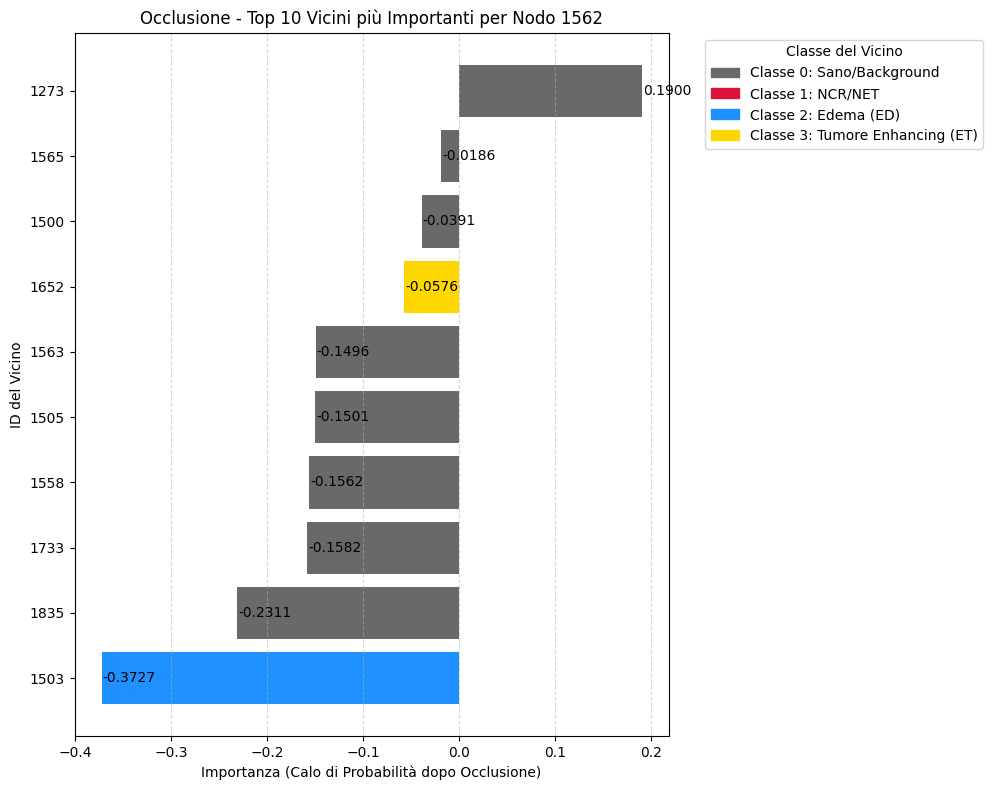

In [16]:
# ======================================================================
#         METODO DI SPIEGABILITÀ 3: ANALISI DI OCCLUSIONE
# ======================================================================
# Si valuta l'importanza di ciascun vicino del nodo target rimuovendolo
# (occludendolo) e misurando il conseguente calo di probabilità della predizione.

import torch.nn.functional as F
import matplotlib.patches as mpatches

print(f"\n--- Analisi di Occlusione per i vicini del nodo: {node_to_explain_index} ---")

# 1. Calcola la probabilità di predizione originale (baseline)
model.eval()
with torch.no_grad():
    original_probs = F.softmax(model(data.x, data.edge_index.type(torch.int64)), dim=1)
    target_class_idx = int(predicted_labels[node_to_explain_index].item())
    original_prob = original_probs[node_to_explain_index, target_class_idx].item()
    
print(f"Probabilità originale per la classe '{classes[target_class_idx]}': {original_prob:.4f}")

# 2. Identifica i vicini del nodo target
edge_index_tensor = data.edge_index
neighbors_in = edge_index_tensor[0, edge_index_tensor[1] == node_to_explain_index]
neighbors_out = edge_index_tensor[1, edge_index_tensor[0] == node_to_explain_index]
all_neighbors = torch.unique(torch.cat([neighbors_in, neighbors_out]))

if len(all_neighbors) == 0:
    print(f"Il nodo {node_to_explain_index} non ha vicini. Analisi non eseguibile.")
else:
    print(f"Il nodo {node_to_explain_index} ha {len(all_neighbors)} vicini. Inizio analisi di occlusione...")
    start_time = time.time()

    # 3. Esegue il ciclo di occlusione
    neighbor_importance = {}
    for neighbor_tensor in all_neighbors:
        # CORREZIONE FINALE: Converti il valore del tensore in un intero
        neighbor_idx = int(neighbor_tensor.item())
        
        mask = ~((edge_index_tensor[0] == node_to_explain_index) & (edge_index_tensor[1] == neighbor_idx) |
                 (edge_index_tensor[0] == neighbor_idx) & (edge_index_tensor[1] == node_to_explain_index))
        perturbed_edge_index = edge_index_tensor[:, mask]
        
        with torch.no_grad():
            perturbed_probs = F.softmax(model(data.x, perturbed_edge_index.type(torch.int64)), dim=1)
            new_prob = perturbed_probs[node_to_explain_index, target_class_idx].item()
        
        neighbor_importance[neighbor_idx] = original_prob - new_prob

    print(f"Analisi completata in {time.time() - start_time:.2f} secondi.")
    
    # 4. Ordina i vicini per importanza e prepara i dati per il plot
    sorted_neighbors = sorted(neighbor_importance.items(), key=lambda item: item[1], reverse=True)
    k_top_neighbors = 10
    top_k_to_plot = sorted_neighbors[:k_top_neighbors]

    # --- 5. Visualizzazione dei Risultati ---
    if top_k_to_plot:
        predicted_labels_np = predicted_labels.cpu().numpy()
        neighbor_ids = [str(n[0]) for n in top_k_to_plot]
        importances = [n[1] for n in top_k_to_plot]
        
        color_map = {0: '#696969', 1: '#DC143C', 2: '#1E90FF', 3: '#FFD700'}
        
        # Ora l'indicizzazione funzionerà perché le chiavi sono interi
        neighbor_colors = [color_map.get(int(predicted_labels_np[neighbor_id]), 'grey') for neighbor_id, _ in top_k_to_plot]

        fig, ax = plt.subplots(figsize=(12, 8))
        ax.barh(neighbor_ids, importances, color=neighbor_colors)
        
        ax.invert_yaxis()
        ax.set_xlabel("Importanza (Calo di Probabilità dopo Occlusione)")
        ax.set_ylabel("ID del Vicino")
        ax.set_title(f"Occlusione - Top {k_top_neighbors} Vicini più Importanti per Nodo {node_to_explain_index}")
        
        for i, bar in enumerate(ax.patches):
            ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2,
                    f'{importances[i]:.4f}', va='center', ha='left')
        
        legend_patches = [mpatches.Patch(color=color, label=f'Classe {i}: {name}') for i, (name, color) in enumerate(zip(classes, color_map.values()))]
        plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Classe del Vicino")
        
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

### 5.2 Metodo Basato sul Gradiente: Saliency Maps

Le **Saliency Maps** sono una delle tecniche XAI più semplici e veloci. Calcolano il gradiente della probabilità della classe predetta rispetto alle feature di input del nodo.

- **Cosa Spiega:** Quali **feature** di input, se leggermente perturbate, causerebbero il maggior cambiamento nel punteggio della classe predetto.
- **Come Funziona:** Un semplice backpropagation.
- **Punti di Forza:** Veloce e facile da implementare. Fornisce una vista "locale" dell'importanza delle feature.


--- Esecuzione di Saliency Maps per il nodo: 1562 ---


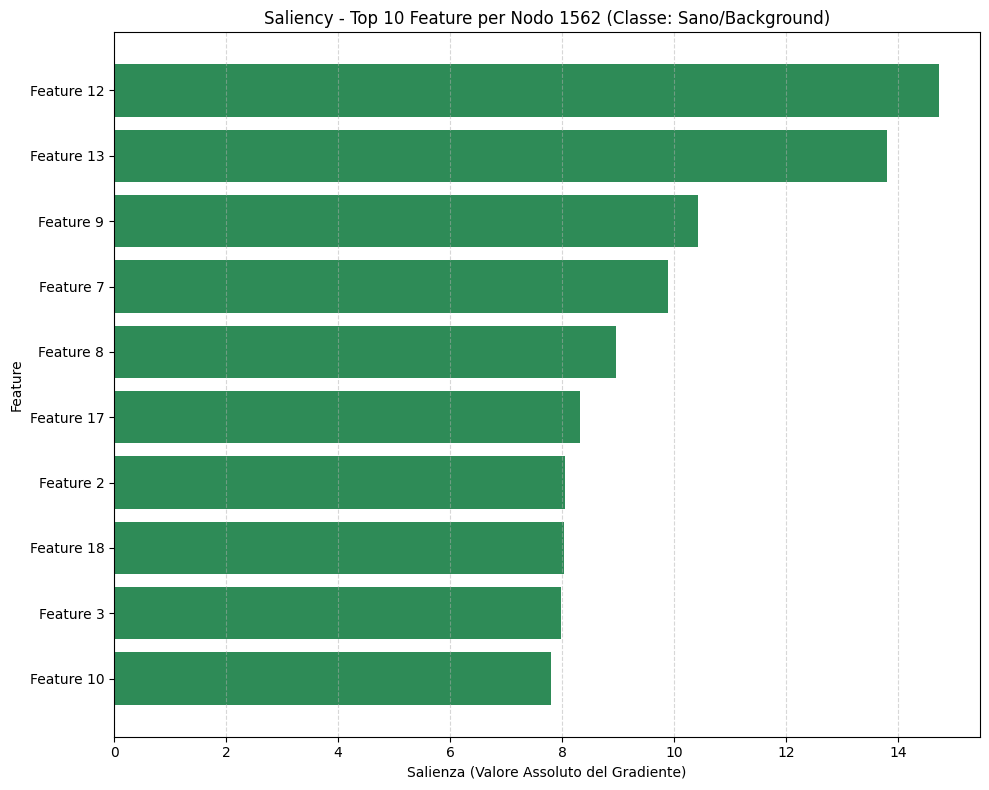


Top 10 feature più salienti per il nodo 1562:
  - Feature 12: Salienza = 14.7229
  - Feature 13: Salienza = 13.8034
  - Feature 9: Salienza = 10.4329
  - Feature 7: Salienza = 9.8900
  - Feature 8: Salienza = 8.9690
  - Feature 17: Salienza = 8.3153
  - Feature 2: Salienza = 8.0522
  - Feature 18: Salienza = 8.0326
  - Feature 3: Salienza = 7.9722
  - Feature 10: Salienza = 7.8001


In [17]:
# ======================================================================
#         METODO DI SPIEGABILITÀ 3: SALIENCY MAPS
# ======================================================================
# Si calcola il gradiente dell'output rispetto all'input per determinare
# quali feature del nodo target sono più influenti per la sua classificazione.

print(f"\n--- Esecuzione di Saliency Maps per il nodo: {node_to_explain_index} ---")

# 1. Prepara l'input per il calcolo del gradiente
x_for_saliency = data.x.clone().requires_grad_(True)
model.zero_grad()  # Azzera i gradienti per una nuova computazione

# 2. Esegue il forward pass per ottenere i logits
logits = model(x_for_saliency, data.edge_index.type(torch.int64))

# 3. Calcola il gradiente rispetto allo score del nodo target
target_class_idx = predicted_labels[node_to_explain_index].item()
score_to_explain = logits[node_to_explain_index, target_class_idx]
score_to_explain.backward()

# 4. Estrae la mappa di salienza per il nodo target
# L'importanza è il valore assoluto del gradiente.
saliency_values = x_for_saliency.grad[node_to_explain_index].abs().cpu().detach().numpy()

# 5. Visualizza le top K feature più salienti
k_top_features = 10
sorted_indices = np.argsort(saliency_values)[-k_top_features:]

top_feature_names = [f"Feature {i}" for i in sorted_indices]
top_importances = saliency_values[sorted_indices]

# Grafico a barre orizzontali
plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(top_feature_names)), top_importances, color='seagreen')
plt.yticks(np.arange(len(top_feature_names)), top_feature_names)
plt.xlabel("Salienza (Valore Assoluto del Gradiente)")
plt.ylabel("Feature")
plt.title(f"Saliency - Top {k_top_features} Feature per Nodo {node_to_explain_index} (Classe: {classes[target_class_idx]})")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Stampa riassuntiva
print(f"\nTop {k_top_features} feature più salienti per il nodo {node_to_explain_index}:")
for name, importance in reversed(list(zip(top_feature_names, top_importances))):
    print(f"  - {name}: Salienza = {importance:.4f}")